In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

🔤 Initializing OCR reader...
✅ OCR reader initialized


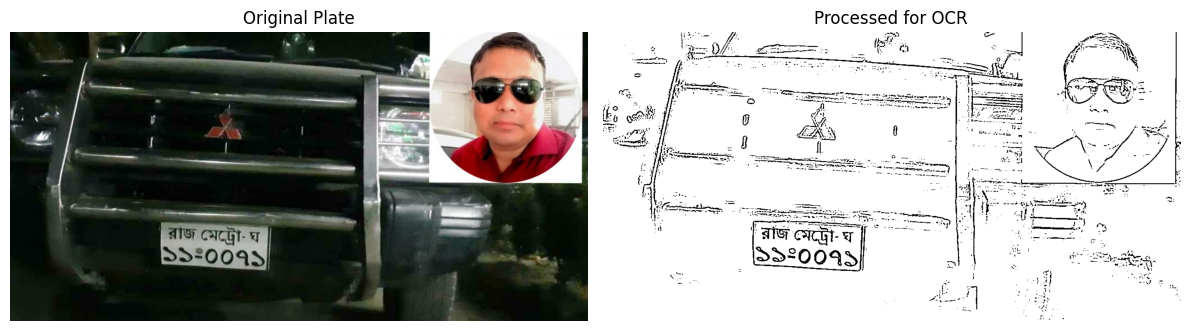

Recognition Result: {'raw_text': 'রাঁজ মেট্রো-ঘ', 'cleaned_text': 'রাঁজ মেট্রো-ঘ', 'confidence': np.float64(0.7162928091769402), 'individual_texts': [{'text': 'রাঁজ মেট্রো-ঘ', 'confidence': np.float64(0.7162928091769402), 'bbox': [[np.int32(322), np.int32(394)], [np.int32(526), np.int32(394)], [np.int32(526), np.int32(448)], [np.int32(322), np.int32(448)]]}], 'is_valid_format': False}


In [ ]:
# Block 3: OCR Module for License Plate Text Recognition
import cv2
import numpy as np
import easyocr
import re
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

class LicensePlateOCR:
    def __init__(self, languages=['bn']):
        """
        Initialize OCR reader for Bengali license plates

        Args:
            languages: List of languages for OCR ('en' for English, 'bn' for Bengali)
        """
        print("🔤 Initializing OCR reader...")
        self.reader = easyocr.Reader(languages, gpu=True)
        print("✅ OCR reader initialized")

    def preprocess_plate_image(self, plate_image):
        """
        Preprocess cropped license plate image for better OCR

        Args:
            plate_image: Cropped license plate image (numpy array)
        """
        # Convert to PIL Image for enhancement
        if isinstance(plate_image, np.ndarray):
            plate_pil = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
        else:
            plate_pil = plate_image

        # Enhance contrast
        enhancer = ImageEnhance.Contrast(plate_pil)
        plate_pil = enhancer.enhance(2.0)

        # Enhance sharpness
        enhancer = ImageEnhance.Sharpness(plate_pil)
        plate_pil = enhancer.enhance(2.0)

        # Convert back to opencv format
        enhanced = cv2.cvtColor(np.array(plate_pil), cv2.COLOR_RGB2BGR)

        # Convert to grayscale
        gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 5
        )

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Resize for better OCR (if too small)
        height, width = cleaned.shape
        if height < 50 or width < 150:
            scale_factor = max(50/height, 150/width)
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)
            cleaned = cv2.resize(cleaned, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        return cleaned

    def extract_text_from_plate(self, plate_image, visualize=False):
        """
        Extract text from license plate image

        Args:
            plate_image: Cropped license plate image
            visualize: Whether to show preprocessing steps
        """
        # Preprocess the image
        processed_image = self.preprocess_plate_image(plate_image)

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Plate')
            axes[0].axis('off')

            axes[1].imshow(processed_image, cmap='gray')
            axes[1].set_title('Processed for OCR')
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

        # Perform OCR
        try:
            results = self.reader.readtext(processed_image)

            if not results:
                # Try with original image if preprocessing failed
                results = self.reader.readtext(plate_image)

            # Extract text with confidence
            extracted_texts = []
            for (bbox, text, confidence) in results:
                if confidence > 0.5:  # Filter low confidence results
                    extracted_texts.append({
                        'text': text.strip(),
                        'confidence': confidence,
                        'bbox': bbox
                    })

            return extracted_texts

        except Exception as e:
            print(f"❌ OCR Error: {e}")
            return []

    def format_bd_license_plate(self, raw_texts):
        """
        Format and validate Bangladeshi license plate patterns

        Common BD formats:
        - Dhaka Metro: ঢাকা মেট্রো গ-১২-৩৪৫৬
        - City format: ঢাকা-গ-১২-৩৪৫৬
        - General: [City]-[Letter]-[Numbers]
        """
        if not raw_texts:
            return None

        # Combine all text
        combined_text = ' '.join([item['text'] for item in raw_texts])

        # Clean up text
        cleaned_text = re.sub(r'[^\u0980-\u09FF\w\s\-]', '', combined_text)

        # Basic validation patterns for BD plates
        patterns = [
            r'[\u0980-\u09FF\w\s]+-[\u0980-\u09FF]+-\d+-\d+',  # City-Letter-Numbers
            r'[\u0980-\u09FF\w\s]+\s+[\u0980-\u09FF]+\s*\d+\s*\d+',  # City Letter Numbers
        ]

        result = {
            'raw_text': combined_text,
            'cleaned_text': cleaned_text,
            'confidence': np.mean([item['confidence'] for item in raw_texts]),
            'individual_texts': raw_texts,
            'is_valid_format': False
        }

        # Check against patterns
        for pattern in patterns:
            if re.search(pattern, cleaned_text):
                result['is_valid_format'] = True
                break

        return result

    def recognize_license_plate(self, plate_image, visualize=False):
        """
        Complete pipeline to recognize license plate text

        Args:
            plate_image: Cropped license plate image
            visualize: Whether to show processing steps
        """
        # Extract text using OCR
        raw_texts = self.extract_text_from_plate(plate_image, visualize)

        if not raw_texts:
            return {
                'success': False,
                'message': 'No text detected',
                'result': None
            }

        # Format and validate
        formatted_result = self.format_bd_license_plate(raw_texts)

        return {
            'success': True,
            'message': 'Text recognized successfully',
            'result': formatted_result
        }

# Enhanced OCR with multiple preprocessing strategies
class AdvancedBDPlateOCR(LicensePlateOCR):
    def __init__(self):
        super().__init__(languages=['en', 'bn'])

    def multi_preprocess_ocr(self, plate_image):
        """
        Try multiple preprocessing strategies and combine results
        """
        strategies = [
            self.preprocess_plate_image,
            self.preprocess_strategy_2,
            self.preprocess_strategy_3
        ]

        all_results = []

        for strategy in strategies:
            try:
                processed = strategy(plate_image)
                results = self.reader.readtext(processed)

                for (bbox, text, confidence) in results:
                    if confidence > 0.3:
                        all_results.append({
                            'text': text.strip(),
                            'confidence': confidence,
                            'bbox': bbox,
                            'strategy': strategy.__name__
                        })
            except:
                continue

        # Remove duplicates and pick best results
        unique_results = {}
        for result in all_results:
            text = result['text']
            if text not in unique_results or result['confidence'] > unique_results[text]['confidence']:
                unique_results[text] = result

        return list(unique_results.values())

    def preprocess_strategy_2(self, plate_image):
        """Alternative preprocessing strategy"""
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply bilateral filter to reduce noise while keeping edges sharp
        filtered = cv2.bilateralFilter(gray, 11, 17, 17)

        # Apply OTSU thresholding
        _, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return thresh

    def preprocess_strategy_3(self, plate_image):
        """Another alternative preprocessing strategy"""
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply histogram equalization
        equalized = cv2.equalizeHist(gray)

        # Apply morphological opening
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(equalized, cv2.MORPH_OPEN, kernel)

        return opened


ocr = LicensePlateOCR()

plate_image = cv2.imread("/content/drive/MyDrive/datasets/test-yolo-1-4-annonations/images/Vehicle1720.jpg")  # Replace with actual image
result = ocr.recognize_license_plate(plate_image, visualize=True)

if result['success']:
    print("Recognition Result:", result['result'])
else:
    print("Recognition failed:", result['message'])

In [ ]:
# Install the ultralytics library
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.7 MB/s eta 0:00:00


In [ ]:
# Block 4: Complete License Plate Detection and Recognition Pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import time
import json
from google.colab.patches import cv2_imshow # Import cv2_imshow


def show_img(title, img, cmap='gray'):
    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


class BDLicensePlateSystem:
    def __init__(self, yolo_model_path, confidence_threshold=0.25):
        """
        Complete system for detecting and recognizing Bangladeshi license plates

        Args:
            yolo_model_path: Path to trained YOLO model
            confidence_threshold: Minimum confidence for detections
        """
        print("🚀 Initializing BD License Plate System...")

        # Load YOLO model
        self.yolo_model = YOLO(yolo_model_path)
        self.confidence_threshold = confidence_threshold

        # Initialize OCR
        # from easyocr import Reader
        # self.ocr_reader = Reader(['bn'], gpu=True)

        # using the AdvancedBDPlateOCR that I ran
        self.ocr_reader = LicensePlateOCR()
        print("✅ OCR reader initialized")

        print("✅ System initialized successfully!")

    def detect_license_plates(self, image):
        """
        Detect license plates in an image using YOLO

        Args:
            image: Input image (numpy array or path)

        Returns:
            List of detected plate regions with coordinates
        """
        # Run YOLO inference
        results = self.yolo_model(image, conf=self.confidence_threshold)

        detected_plates = []

        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    # Get coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()

                    detected_plates.append({
                        'bbox': [int(x1), int(y1), int(x2), int(y2)],
                        'confidence': float(confidence)
                    })

        return detected_plates

    def crop_license_plate(self, image, bbox, padding=10):
        """
        Crop license plate region from image with padding

        Args:
            image: Original image
            bbox: Bounding box [x1, y1, x2, y2]
            padding: Padding around the plate
        """
        x1, y1, x2, y2 = bbox
        h, w = image.shape[:2]

        # Add padding
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(w, x2 + padding)
        y2 = min(h, y2 + padding)

        # print the iamge
        show_img("cropped image",image[y1:y2, x1:x2])

        return image[y1:y2, x1:x2]

    def preprocess_plate_for_ocr(self, plate_image):
        """Enhanced preprocessing for Bengali plates"""
        # Convert to grayscale
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(gray, 11, 17, 17)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Resize if too small
        h, w = cleaned.shape
        if h < 50 or w < 150:
            scale = max(50/h, 150/w)
            new_h, new_w = int(h * scale), int(w * scale)
            cleaned = cv2.resize(cleaned, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        return cleaned

    def recognize_text(self, plate_image):
        """
        Recognize text from license plate image
        """
        # Preprocess image
        processed = self.preprocess_plate_for_ocr(plate_image)

        # Perform OCR
        try:
            # results = self.ocr_reader.recognize_license_plate(processed, visualize=True)

            # If no results, try with original image
            # if not results:

            results = self.ocr_reader.recognize_license_plate(plate_image, visualize=True)


            extracted_texts = []
            if result['success']:
                print("Recognition Result:", result['result'])
                extracted_texts.append({
                        'text': results['raw_text'],
                        'confidence': results['confidence']
                    })

            # Extract text with confidence
            # Check if the results dictionary contains the expected structure
            if results and 'best_result' in results and 'individual_texts' in results['best_result']:
                for item in results['best_result']['individual_texts']:
                    if item['confidence'] > 0.4:  # Filter low confidence
                        extracted_texts.append({
                            'text': results['raw_text'],
                            'confidence': item['confidence']
                        })

            return extracted_texts

        except Exception as e:
            print(f"OCR Error: {e}")
            return []

    def process_single_image(self, image_path, visualize=True):
        """
        Complete pipeline for single image processing

        Args:
            image_path: Path to input image
            visualize: Whether to show results
        """
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            return {"error": "Could not load image"}

        start_time = time.time()

        # Step 1: Detect license plates
        detected_plates = self.detect_license_plates(image)

        if not detected_plates:
            return {
                "success": False,
                "message": "No license plates detected",
                "processing_time": time.time() - start_time
            }

        # Step 2: Process each detected plate
        results = []

        for i, plate_info in enumerate(detected_plates):
            bbox = plate_info['bbox']
            detection_conf = plate_info['confidence']

            # Crop plate region
            cropped_plate = self.crop_license_plate(image, bbox)

            # Recognize text
            ocr_results = self.recognize_text(cropped_plate)

            # Combine text
            combined_text = ' '.join([item['text'] for item in ocr_results])
            avg_confidence = np.mean([item['confidence'] for item in ocr_results]) if ocr_results else 0

            results.append({
                'plate_id': i + 1,
                'bbox': bbox,
                'detection_confidence': detection_conf,
                'recognized_text': combined_text,
                'ocr_confidence': avg_confidence,
                'individual_texts': ocr_results
            })

        processing_time = time.time() - start_time

        # Visualize results
        if visualize:
            self.visualize_results(image, results)

        return {
            "success": True,
            "image_path": str(image_path),
            "num_plates_detected": len(results),
            "results": results,
            "processing_time": processing_time
        }

    def visualize_results(self, image, results):
        """
        Visualize detection and recognition results
        """
        # Create a copy for visualization
        vis_image = image.copy()

        # Draw bounding boxes and text
        for result in results:
            bbox = result['bbox']
            text = result['recognized_text']
            det_conf = result['detection_confidence']
            ocr_conf = result['ocr_confidence']

            x1, y1, x2, y2 = bbox

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Prepare label
            label = f"Plate {result['plate_id']}: {text}"
            conf_label = f"Det: {det_conf:.2f}, OCR: {ocr_conf:.2f}"

            # Draw labels
            cv2.putText(vis_image, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(vis_image, conf_label, (x1, y2+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Display result using cv2_imshow
        # plt.figure(figsize=(12, 8)) # Disabled in Colab
        # plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)) # Disabled in Colab
        # plt.title("License Plate Detection and Recognition Results") # Disabled in Colab
        # plt.axis('off') # Disabled in Colab
        # plt.tight_layout() # Disabled in Colab
        # plt.show() # Disabled in Colab
        cv2_imshow(vis_image)

    def process_video(self, video_path, output_path=None, max_frames=None):
        """
        Process video for license plate detection

        Args:
            video_path: Path to input video
            output_path: Path to save output video
            max_frames: Maximum frames to process (None for all)
        """
        cap = cv2.VideoCapture(str(video_path))

        if not cap.isOpened():
            return {"error": "Could not open video"}

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Setup video writer if output path provided
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        all_results = []

        print(f"Processing video: {total_frames} frames at {fps} FPS")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if max_frames and frame_count >= max_frames:
                break

            # Process frame
            detected_plates = self.detect_license_plates(frame)

            # Draw results on frame
            for plate_info in detected_plates:
                bbox = plate_info['bbox']
                conf = plate_info['confidence']

                x1, y1, x2, y2 = bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Plate: {conf:.2f}", (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Save frame if output writer exists
            if output_path:
                out.write(frame)

            # Store results
            all_results.append({
                'frame': frame_count,
                'detections': detected_plates
            })

            frame_count += 1

            if frame_count % 30 == 0:  # Progress update every 30 frames
                print(f"Processed {frame_count}/{total_frames} frames")

        # Cleanup
        cap.release()
        if output_path:
            out.release()

        return {
            "success": True,
            "total_frames": frame_count,
            "results": all_results,
            "output_path": output_path
        }

    def batch_process_images(self, image_dir, output_file="batch_results.json"):
        """
        Process multiple images in a directory

        Args:
            image_dir: Directory containing images
            output_file: JSON file to save results
        """
        image_dir = Path(image_dir)
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

        # Find all images
        image_files = []
        for ext in image_extensions:
            image_files.extend(image_dir.glob(f"*{ext}"))
            image_files.extend(image_dir.glob(f"*{ext.upper()}"))

        print(f"Found {len(image_files)} images to process")

        all_results = []

        for i, image_path in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {image_path.name}")

            result = self.process_single_image(image_path, visualize=False)
            all_results.append(result)

        # Save results
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

        print(f"✅ Batch processing complete! Results saved to: {output_file}")

        # Summary statistics
        successful = sum(1 for r in all_results if r.get('success', False))
        total_plates = sum(r.get('num_plates_detected', 0) for r in all_results)
        avg_time = np.mean([r.get('processing_time', 0) for r in all_results])

        print(f"📊 Summary:")
        print(f"  Successful processes: {successful}/{len(image_files)}")
        print(f"  Total plates detected: {total_plates}")
        print(f"  Average processing time: {avg_time:.2f}s")

        return all_results

🚀 Initializing BD License Plate System...
🔤 Initializing OCR reader...
✅ OCR reader initialized
✅ OCR reader initialized
✅ System initialized successfully!

0: 416x640 1 license_plate, 43.4ms
Speed: 1.9ms preprocess, 43.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


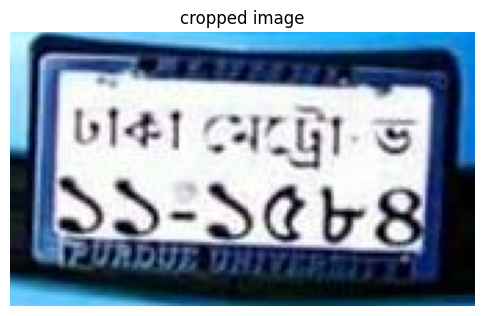

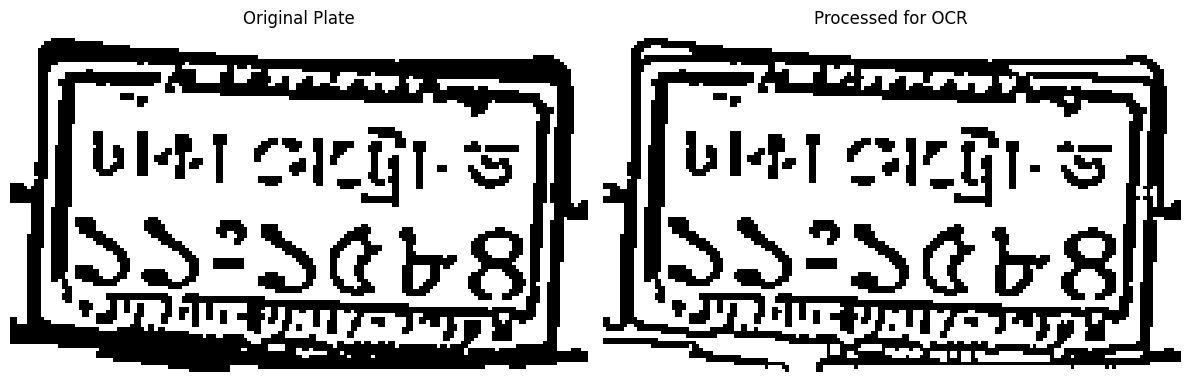

OCR Error: 'result'


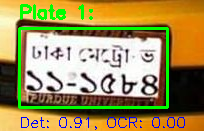

Single image result: {'success': True, 'image_path': '/content/drive/MyDrive/datasets/train-test-YOLO-1/test-1/dataset/images/train/360.jpg', 'num_plates_detected': 1, 'results': [{'plate_id': 1, 'bbox': [19, 28, 167, 107], 'detection_confidence': 0.9089586138725281, 'recognized_text': '', 'ocr_confidence': 0, 'individual_texts': []}], 'processing_time': 0.7069661617279053}


In [ ]:
# Initialize the complete system
system = BDLicensePlateSystem(
    yolo_model_path="/content/drive/MyDrive/datasets/test-yolo-2-4-annotations/bd_license_plate_detector.pt",  # Your trained model
    confidence_threshold=0.2
)

# Test on single image
result = system.process_single_image("/content/drive/MyDrive/datasets/train-test-YOLO-1/test-1/dataset/images/train/360.jpg")
print("Single image result:", result)

# # Batch process images
# batch_results = system.batch_process_images("/content/drive/MyDrive/datasets/train-test-25/train")
# # print("Batch processing complete!")